# ODSC West 2022 Tutorial: 
### Objective: Illustrate the pros and cons of using frequency domain analyses for this problem
- Kirstin Aschbacher
- Sept 2022

##### Tutorial Goals:
* This tutorial focuses on the practical application of these techniques and building of data intuition
* See how multiple sine waves can be summated to create a complex wave resembling real RR interval data
* Understand how to analyze this data to obtain metrics in the frequency domain
* Learn how to conduct frequency domain analyses on irregularly spaced observations like RR intervals
* Learn how to visualize the results of these analyses
* Gain intuition for how frequency metrics can become less accurate and contaminated when we analyze very short windows of data, as is required for real-time modeling.


In [1]:
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

pd.set_option("display.width", 500)
np.printoptions("precision", 2)

WAVELENGTH = 180  # seconds of data to be analyzed and plotted

#### Helper functions to build a simple sinewave and a tilted sinewave, then plot

In [2]:
def build_sine(
    time: np.ndarray, amp: float, omg: float, phi: float=np.deg2rad(0), yint: float=0
) -> np.ndarray:
    """Helper function to build a sine wave, given a 1d numpy array representing time
    and the four sine wave parameter values"""
    return amp * np.sin((time * omg) + phi) + yint

def build_tilted_sine(
    time: np.ndarray, amp: float, omg: float, phi: float=np.deg2rad(0), yint: float=0
) -> np.ndarray:
    """y=sin(pi*2x + sin(pi*2x)/2)"""
    return amp * np.sin(time * omg + ((np.sin(time * omg) + phi)/-2) + phi) + yint

def plot_wave(time: np.ndarray, series: np.ndarray, color: str="navy", title: str=None) -> None:
    plt.figure(figsize=(10, 3))
    plt.plot(time, series, color=color)
    if title is None:
        title = "Waveform Data"
    plt.title(title, fontsize=16)
    plt.xlabel("Time (seconds)", fontsize=12)
    plt.ylabel("RR Intervals", fontsize=12)
    plt.show()

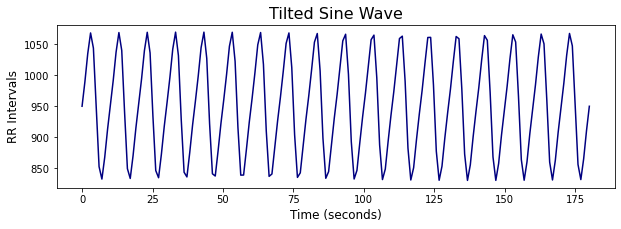

In [3]:
# Create a sine wave that has units similar to a plot of RR intervals during HRVB
time = np.linspace(0, WAVELENGTH, WAVELENGTH) # 3 minutes of data, with time as seconds
amp = 120; omg = .1*2*np.pi; phi = 0; yint = 950

tilted_sine = build_tilted_sine(time, amp, omg, phi, yint)
plot_wave(time, tilted_sine, title="Tilted Sine Wave")

#### Now let's build a more complex waveform of mock data
* Include multiple frequencies
* Introduce time irregularities to better resemble actual data

In [4]:
def build_complex_waveform(time: np.ndarray) -> np.ndarray:
    """Add multiple sine waves together to get a complex waveform that resembles an RR series"""
    tilted_sine = build_tilted_sine(time, amp=120, omg=.1*2*np.pi, phi=0, yint=950)
    low_freq = build_tilted_sine(time, amp=30, omg=.067*2*np.pi, phi=220, yint=0)
    high_freq = build_sine(time, amp=10, omg=.23*2*np.pi, phi=np.deg2rad(10), yint=0)
    high_freq2 = build_sine(time, amp=10, omg=.23*2*np.pi, phi=np.deg2rad(15), yint=0)
    high_freq3 = build_sine(time, amp=20, omg=.38*2*np.pi, phi=np.deg2rad(17), yint=0)
    vl_freq = build_sine(time, amp=50, omg=.0125*np.pi, phi=np.pi, yint=0)
    return tilted_sine + low_freq + high_freq + high_freq2 + high_freq3 + vl_freq

def make_irregular(complex_wave: np.ndarray) -> np.ndarray:
    """Adding brief reflections and deletions to better reflect how real users
    vary the pace of their breathing in practice."""
    starting_size = complex_wave.size
    complex_wave = np.concatenate(
        (complex_wave[:44], np.flip(complex_wave[42:44]), complex_wave[46:123], 
        np.flip(complex_wave[120:125]), complex_wave[125:160], complex_wave[163:])
    )
    assert complex_wave.size == starting_size
    return complex_wave

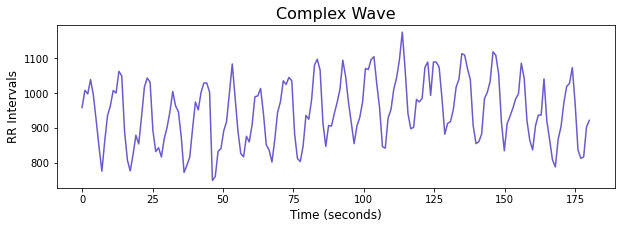

In [5]:
time = np.linspace(0, WAVELENGTH, WAVELENGTH) # 3 minutes of data, with time as seconds
complex_wave = build_complex_waveform(time)
complex_wave = make_irregular(complex_wave)
plot_wave(time, complex_wave, color="slateblue", title="Complex Wave")

#### Load & plot actual test data from one user

In [6]:
# Load data from a csv
hrv_fpath = "data/odsc_testdata_edited.csv"
df_hrv = pd.read_csv(hrv_fpath, encoding="utf-8", index_col="rawrrID")

# Compute the time vector. Convert RR's into units=seconds
first = df_hrv["rawRR"].iloc[0] / 1000
df_hrv["time"] = df_hrv["rawRR"].cumsum() / 1000 - first

# To keep the units more straightforward, we'll use the RR intervals, not HR bpm
# hrv_df["heartRate"] = np.divide(60000, hrv_df["rawRR"])

# Truncate to make this signal a similar length to the mock data
print(f"Prior to truncation df.shape = {df_hrv.shape}")
df = df_hrv.loc[df_hrv["time"] <= WAVELENGTH].copy(deep=True)
print(f"After truncation df.shape = {df.shape}")
df.head(3)



Prior to truncation df.shape = (320, 2)
After truncation df.shape = (186, 2)


,rawRR,time
rawrrID,,
0,843,0.000
1,882,0.882
2,914,1.796


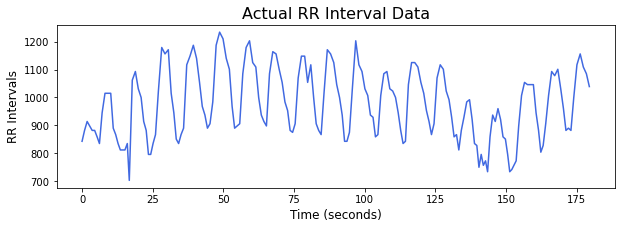

In [7]:
# Plot the RR series
time = df["time"].values
signal = df["rawRR"].values
plot_wave(time, signal, color="royalblue", title="Actual RR Interval Data")

#### Let's analyze these data in the frequency domain
* We will use LombScargle because the intervals between the heart beats are not evenly spaced
* Prior studies show that LombScargle performs better than FFT on heart rate data.
* https://eecs.wsu.edu/~sgupta/Papers/Conf/Gupta_Delane_Schiavenato_Bohorquez_2016_EMBS.pdf

#### But first, let's do a little wrangling to get an irregularly sampled sine wave and complex wave

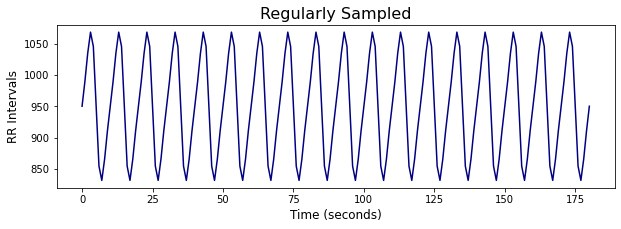

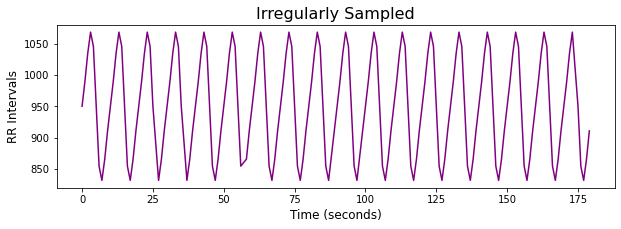

Example values of the actual RR intervals:
[843 882 914 898 882]

The values from the complex wave, which resemble RR intervals:
[ 958  958 1008  997 1039]


In [8]:
# Use millisecond resolution to match RRs
time = np.linspace(0, WAVELENGTH, WAVELENGTH * 1000, dtype=np.int64)
amp = 120; omg = .1*2*np.pi; phi = 0; yint = 950

tilted_sine = build_tilted_sine(time, amp, omg, phi, yint)
complex_wave = build_complex_waveform(time)
complex_wave = make_irregular(complex_wave)

# Now, we want to use df_time as the index to sample irregularly, so it must be scaled to ms
df_time = (df["time"].values * 1000).astype(int)  
plot_wave(time, tilted_sine, title="Regularly Sampled")

# Build new vectors for time and our waveform that are irregularly sampled just as in the real data
time_irreg = time[df_time]
tilted_sine_irreg = tilted_sine[df_time]
plot_wave(time_irreg, tilted_sine_irreg, color="purple", title="Irregularly Sampled")

# Same for complex wave
complex_wave_irreg = complex_wave[df_time].astype(int)
print(f"Example values of the actual RR intervals:\n{df['rawRR'][:5].values}\n")
print(f"The values from the complex wave, which resemble RR intervals:\n{complex_wave_irreg[:5]}")

# Confirm assumptions that wrangling worked as expected
assert time[df_time].size == tilted_sine[df_time].size
assert time[df_time].size == df["time"].size
assert time[df_time].size == complex_wave[df_time].size

In [9]:
def compute_lombscargle(time: np.ndarray, series: np.ndarray) -> List[np.ndarray]:
    """The Lomb-Scargle periodogram fits a sinusoidal model to the data at each frequency.
    Larger power (or psd) reflects better fit. When normalization="psd", it has units y**2 for some signal y.
    The min and max frequency bounds were chosen based on commonly used research 
    definitions of VLF and HF. (Note that longer timeseries are needed to accurately compute VLF.)
    Schaffer and Ginsberg (2017): https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624990/
    """
    # See: https://docs.astropy.org/en/stable/timeseries/lombscargle.html
    ls = LombScargle(time, series, normalization="log")
    freq, psd = ls.autopower(minimum_frequency=.0033, maximum_frequency=.4)
    # You may want to compute the false alarm probability of observing this power peak under Ho
    fap = ls.false_alarm_probability(psd.max())
    return freq, psd

def plot_freq_by_power(freq: np.ndarray, psd: np.ndarray, color: str = "navy", title: str = "") -> None:
    """Plot frequency by power results from lombscargle analysis"""
    plt.figure(figsize=(8, 2.25))
    plt.plot(freq, psd, color=color)
    plt.xlabel("Frequency (Hz)", fontsize=12)
    plt.ylabel("Lomb-Scargle Power", fontsize=12)
    plt.title(f"Spectral Analysis: {title}", fontsize=14)
    plt.show()

def compute_and_plot_lsp(time: np.ndarray, signal: np.ndarray, color: str, title: str) -> None:
    freq, psd = compute_lombscargle(time, signal)
    plot_freq_by_power(freq, psd, color, title)

#### Compute and Plot the Lomb Scargle on all three signals, which vary in their component frequencies
* The range of the y-axis are different, but across all the figures below, we see that
* the predominant frequency detected corresponds to the breathing frequency.
* We can also see that the pure sine wave has almost no power in other frequencies, except .20, which is a harmonic.

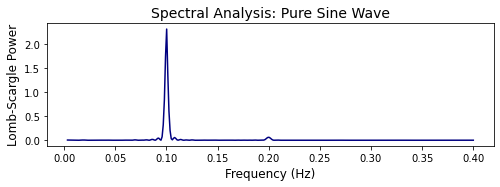

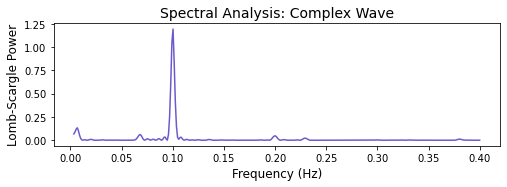

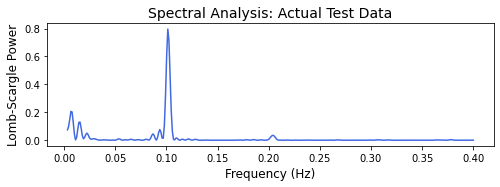

In [10]:
# Set up vectors
time = df["time"].values
signal_realdata = np.divide(df["rawRR"], 1000).values

# Prepare to plot each of the 3 waveforms in one figure
time_arrs = [time, time, time]
signal_arrs = [tilted_sine_irreg, complex_wave_irreg, signal_realdata]
colors = ["navy", "slateblue", "royalblue"]
titles = ["Pure Sine Wave", "Complex Wave", "Actual Test Data"]

n_plots = len(time_arrs)
assert n_plots == len(signal_arrs) == len(colors) == len(titles)

# Iterate and Plot
for i in range(n_plots):
    time = time_arrs[i]
    signal = signal_arrs[i]
    color = colors[i]
    title = titles[i]
    if time.shape != signal.shape:
        raise ValueError(f"In i={i}, time.shape={time.shape}, while signal.shape={signal.shape}")

    compute_and_plot_lsp(time, signal, color, title)

### Another helpful way to visualize this data is using a spectrogram

In [11]:
def plot_spectrogram(rr: np.ndarray, cmap: str='twilight', title_add: str="") -> None:
    """A graphing function to plot a spectrogram, given a 1dim time series vector 'rr' """
    plt.figure(figsize=(10, 3))
    plt.specgram(x=rr, Fs=1, NFFT=30, noverlap=28, cmap=cmap)
    plt.xlabel("Time (seconds)", fontsize=12)
    plt.ylabel("Frequency (Hz)", fontsize=12)
    plt.title(f"Spectrogram {title_add}", fontsize=14)
    plt.colorbar()
    plt.show()

#### Let's see how the full time series of actual data looks plotted
* This test user began by doing HRV Biofeedback at 6 breaths per minute.
* Around 200 seconds, the user stopped doing HRVB and started breathing very quickly ("breath of fire").  
* You can see that this eliminates the large sinusoidal waveform generated by HRVB.  
* Then, for about the last 40 seconds, the user returns to HRVB at 6 breaths per minute.

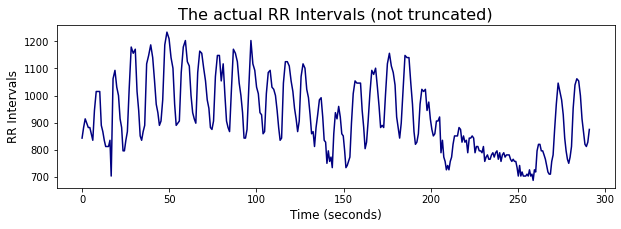

In [12]:
# First, plot the RR series
time = df_hrv["time"].values
signal = df_hrv["rawRR"].values
plot_wave(time, signal, color="navy", title="The actual RR Intervals (not truncated)")

#### Next, plot a spectrogram
* Below, the spectrogram reveals orange horizontal bands around a frequency of .1
* .1 Hz corresponds to a pace of 6 breaths per minute, which is the rate of the pacer. 
* When the user begins to breathe quickly, that orange band disappears, and high frequencies are introduced.

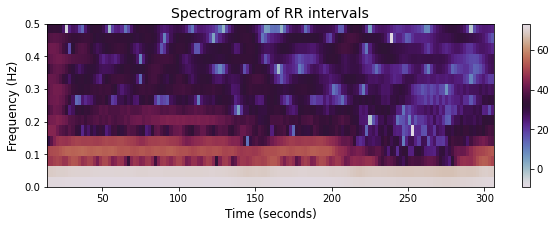

In [13]:
Fs = 1.0 # Sampling frequency.  We will set it to seconds
rr = df_hrv["rawRR"].values  # convert ms to seconds
plot_spectrogram(rr, title_add="of RR intervals")

### Gain intuition into the time-frequency trade-offs
* An in-depth mathematical explanation is beyond the scope of this tutorial, but here's the gist:
* Power estimates become less accurate when using small windows of data
* This is because there are trade-offs between the time and frequency domains,
* With shorter and shorter windows of data, accurate capture of intensity in specific frequencies is reduced

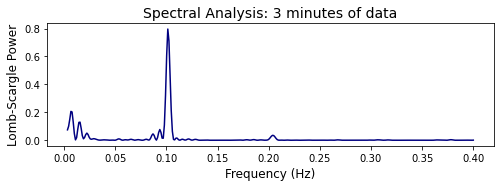

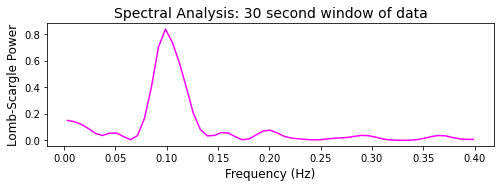

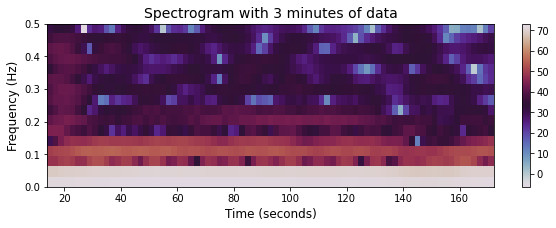

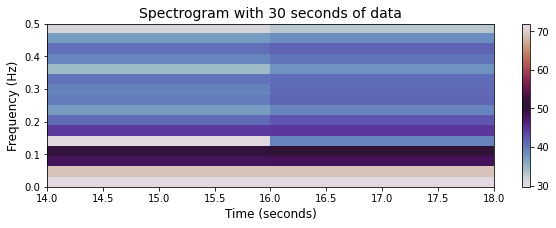

In [14]:
# Below, you can see that the ability to identify power within a narrow frequency band
# becomes much less precise on brief windows of data

time = df["time"].values
rr = df["rawRR"].values

W_LENGTH = 30
idx = np.where(df["time"] <= W_LENGTH)
short_time = df.loc[idx, "time"].values
short_signal = df.loc[idx, "rawRR"].values

compute_and_plot_lsp(time, rr, "navy", "3 minutes of data")
compute_and_plot_lsp(short_time, short_signal, "magenta", "30 second window of data")

plot_spectrogram(rr, title_add="with 3 minutes of data")
plot_spectrogram(short_signal, title_add="with 30 seconds of data")

### Conclusions

* You've learned how to extract frequency information from a signal using the Lomb-Scargle algorithm
* When extracting frequency information from RR-intervals, we use Lomb because the intervals are not evenly spaced
* You have learned observed how the results are impacted by the underlying frequencies composing the signal
* Low power frequency metrics are the gold-standard method used in most research studies of heart rate variability biofeedback. However, in these research studies, the Lomb is being applied "retrospectively" to the whole signal AFTER the entire time series waveform is collected.
* In real-time, we have to give the user feedback every few seconds, so we have to analyze small rolling windows of data at a time.
* You have seen how the power extracted in the breathing frequency range becomes less accurate when using a brief window of the signal, as required for real-time biofeedback analysis.
* Also, edge effects can contaminate the data integrity, which is sometimes handled by cutting roughly 3 cycles of data from the sides of the time series.  In this case, 3 cycles would be 30 seconds, which is the length we want to compute on.  Thus, such a small window poses challenges when using these methods.


#### Next, we will explore an alternative model for real-time use